# Simple HMM in NumPy or PyTorch

In [1]:
%run ../prongen/hmm_pron.py

Test of the hmm_pron library - generate Czech pron HMM
args.__dict__={'ctu_phone_symbols': True, 'all_begins': False, 'all_ends': False}
sen='k dohodě došlo již dlouho předtím'
                            ť
g=dohoďe došlo jyš|dlOho pŘetťým
                 ž_
sg=[{'g=dohoďe došlo jy'}, {'ž_', 'š|'}, {'dlOho pŘe'}, {'t', 'ť'}, {'ťým'}]

                             ť
|g=dohoďe došlo jyš|dlOho pŘetťým|
                  ž_
sg=[{'|'}, {'g=dohoďe došlo jy'}, {'ž_', 'š|'}, {'dlOho pŘe'}, {'t', 'ť'}, {'ťým'}, {'|'}]

               |         |
|g.dohoďe.došlo.jyš|dlOho.pŘetťým|
         |        ž          ť
sg=[{'|'}, {'g'}, {''}, {'d'}, {'o'}, {'h'}, {'o'}, {'ď'}, {'e'}, {'', '|'}, {'d'}, {'o'}, {'š'}, {'l'}, {'o'}, {'', '|'}, {'j'}, {'y'}, {'š|', 'ž'}, {'d'}, {'l'}, {'O'}, {'h'}, {'o'}, {'', '|'}, {'p'}, {'Ř'}, {'e'}, {'t', 'ť'}, {'ť'}, {'ý'}, {'m'}, {'|'}]

------ sentence and HMM ------
 WAV: /home/hanzl/f-w/prak/common_voice_cs_23962589.wav
ORTO: k dohodě došlo již dlouho předtím
     

In [2]:
%run ../acmodel/plot.py
%matplotlib ipympl

In [3]:
%run ../acmodel/matrix.py

In [4]:
import torchaudio
waveform, sample_rate = torchaudio.load(hmm.wav)
mfcc = torchaudio.compliance.kaldi.mfcc(waveform) # default 16kHz is correct for this file

In [5]:
A = m([[0.7,0.3,0,0],
       [0,0.9,0.1,0],
       [0,0,0.8,0.2],
       [0,0,0,1]])

A = m(hmm.A)

In [6]:
A.size()[0]

35

In [7]:
# where we can be
#x_m = m([[1,0,0,0]])
x_list = [1,0,0,0]
x_list = [1]+[0]*(A.size()[0]-1)
x_m = m([x_list])
x_rev = m([list(reversed(x_list))])

In [8]:
x_m.size()

torch.Size([1, 35])

In [9]:
# recording length in frames
tmax = 14000

tmax = 363

tmax = int(363/35 * A.size()[0])
tmax

363

In [10]:
len_x = x_m.size()[1]

# allocate space for mantissa-like (kept in range) and row-exponent values
alpha_m = m.rowlist((tmax,len_x))
alpha_exp = m.rowlist((tmax,1))

exponent = 0
base = 1000 # base for separation to exp and m (somewhere around 5e-324 starts underflow)

In [11]:
# FAKE b VALUES:
b = m.zeros((tmax,len_x)) + 0.1

In [12]:
#x_m = m([[1,0,0,0]]) 

In [13]:
%%time
#x_m = m([[1,0,0,0]]) # mantissa-like moderated value (kept in range)
for row in range(tmax):
    while x_m.max()<1/base: # renormalize and remember power of base used
        x_m *= base
        exponent -= 1
    alpha_exp[row] = exponent
    alpha_m[row] = x_m
    x_m = x_m@A*b[row]   # FINETUNE WHICH row's b IS USED (ALSO FOR beta)

CPU times: user 62.8 ms, sys: 0 ns, total: 62.8 ms
Wall time: 7.81 ms


### Size 14000 x 4
* GPU: 7.01 torch sparse coo, NotImpl torch sparse csr, 0.384 torch dense
* CPU: 1.54 torch sparse coo, 0.210 torch sparse csr, 0.214 torch dense

### Size 363 x 35
* GPU: ??? torch sparse coo, NotImpl torch sparse csr, 0.3770 torch dense
* CPU: ??? torch sparse coo, NotImpl torch sparse csr, 0.0054 torch dense

715 15.4 CPU 391 GPU

1420 33  CPU 434 GPU

2831  78.5 CPU 486 GPU

5652  209  CPU  612 GPU

11294  529 CPU  885 GPU

22578    5000 CPU   1860 GPU

45146    120000 CPU  6110 GPU   unusable GPU coo   not impl CPU csr   unusable CPU coo


In [14]:
# Now we will go backward
At = A.T()

In [15]:
beta_m = m.rowlist((tmax,len_x))
beta_exp = m.rowlist((tmax,1))

exponent = 0

In [16]:
#x_m = m([[0,0,0,1]])
x_m = x_rev
for row in range(tmax-1,0-1,-1):
    beta_m[row] = x_m
    beta_exp[row] = exponent
    x_m = x_m@At*b[row]
    while x_m.max()<1/base: # renormalize and remember power of base used
        x_m *= base
        exponent -= 1

In [17]:
L_m = alpha_m*beta_m # this is .*

In [18]:
L_exp = alpha_exp+beta_exp

In [19]:
L_exp += float(-L_exp.max())

In [20]:
# re-normalize L
for row in range(tmax):
    while float(L_exp[row].val)<0: # renormalize and remember power of base used
        L_m[row] *= 1/base  # invokes setitem which converts L_m to dense
        L_exp[row] += 1

In [21]:
L_m.size()

torch.Size([363, 35])

In [22]:
# test - should be the same now
L_exp.min(), L_exp.max()

(tensor(0.), tensor(0.))

In [23]:
L_m.max() # happens to be also equal to sum of any row in L_m

tensor(2.0233e-31)

In [24]:
X = (L_m*(1/float(L_m.max()))).val
# now sum of any row in X is 1, we will use these probabilities to compute means

In [25]:
X.size()

torch.Size([363, 35])

In [26]:
scale = 1/X.max(1).values
Y = (X.T*scale).T

In [27]:
X.sum(dim=1).size()

torch.Size([363])

In [28]:
means = (X[:,None]*mfcc[:,:,None]).sum(dim=0) # sizes like [363, 1, 35] and [363, 13, 1]
means.size()
# yet to be summed to phonemes

torch.Size([13, 35])

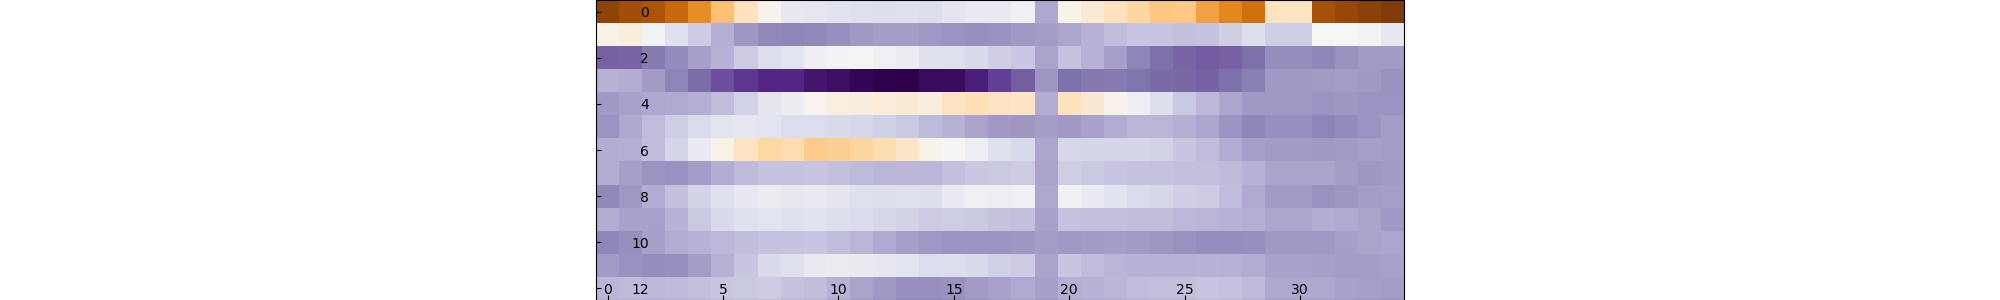

In [29]:
plot_matrix(means.T)

In [30]:
weights = X.sum(dim=0)
weights

tensor([11.1212, 11.1212, 11.1212, 11.1212, 11.1212, 11.1212, 11.1212, 11.1212,
        10.1212, 11.1212, 11.1212, 11.1212, 11.1212, 11.1212, 10.1212, 11.1212,
        11.1212, 10.1212, 10.1212,  1.0000, 11.1212, 11.1212, 11.1212, 11.1212,
        11.1212, 10.1212, 11.1212, 11.1212, 11.1212,  5.5606,  5.5606, 11.1212,
        11.1212, 11.1212, 11.1212])

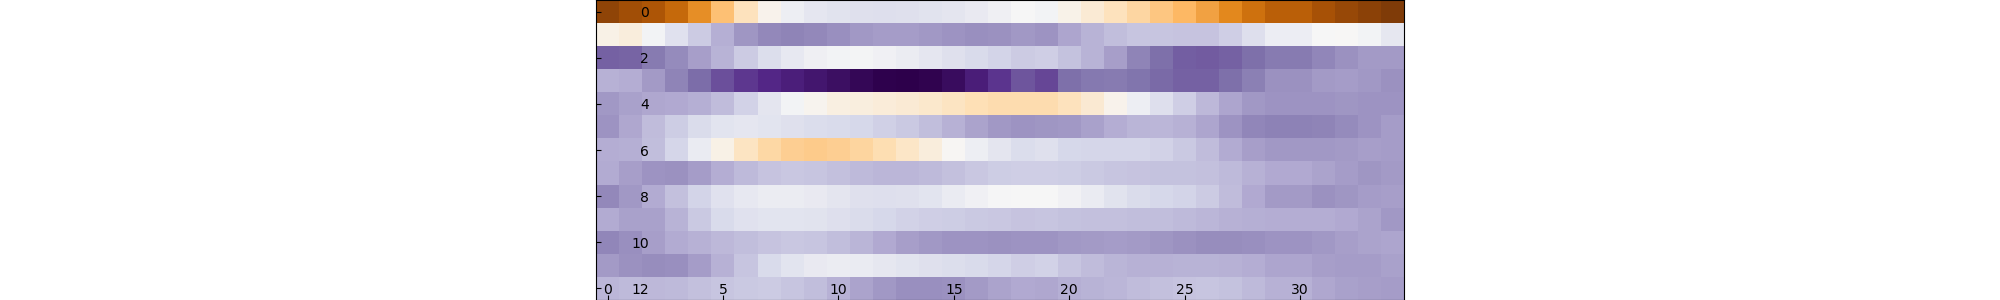

In [31]:
plot_matrix((means/weights).T)

In [32]:
# put this cell up
acc_means = {} # can as well be a vector of numbers (later)
acc_weights = {}

In [33]:
means.size()

torch.Size([13, 35])

In [34]:
for i, phone in enumerate(hmm.b): # now b is string, may be a list of strings later
    if phone not in acc_means:
        acc_means[phone] = 0 # will be broadcast to the right size
        acc_weights[phone] = 0
        
    acc_means[phone] += means[:,i]
    acc_weights[phone] += weights[i]


In [35]:
b_means = {}
for phone in acc_means:
    b_means[phone] = acc_means[phone]/acc_weights[phone]

In [36]:
b_means

{'|': tensor([-38.8115,  -7.2294,  -3.2720,  10.0266, -13.6986,  -3.2217, -13.4799,
          -5.1625,  -9.7336,  -6.3415,  -0.1130,  -6.8232,  -3.2362]),
 'g': tensor([-62.0157, -25.0698,   8.9930,  -2.6958,  -0.6238,  -1.8598,  -3.2706,
          -0.3707,   1.0607,  -0.6708,   2.3584,   1.8197,  -5.3702]),
 'd': tensor([-33.0070,  -5.7855,  -6.6284,   9.4893, -17.9728,  -5.9193, -17.5625,
          -5.0533, -12.9558,  -7.3843,  -2.3206,  -7.2516,  -4.7926]),
 'o': tensor([-31.5494,  -4.5321,  -6.1946,  14.5469, -14.3609,  -9.7933, -21.4110,
          -3.8300, -12.2557,  -9.1882,  -2.4903,  -7.4868,  -4.2223]),
 'h': tensor([-40.0140,  -8.1360,   1.9641,   7.4022, -10.6517,  -8.3283, -14.0147,
          -3.4942, -11.6744,  -7.2888,  -1.6549,  -1.7054,  -6.0215]),
 'ď': tensor([-29.3493,   1.1516,  -8.5985,  14.6403, -10.3198, -15.7213, -28.6380,
          -5.4039, -16.4652, -14.3723,  -6.2394,  -7.7209,  -8.4291]),
 'e': tensor([-37.7916,  -4.9854,  -2.7372,  10.7669,  -7.3686,  -5.62

In [37]:
b

m(tensor([[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        ...,
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]]))

In [38]:
b.size(), mfcc.size()

(torch.Size([363, 35]), torch.Size([363, 13]))

### Note: May need to disallow loop at silence states between words in first iterations?
Or even share means of all non-silence phones for the first passes. (Loops could be added back easily by adding the full diagonal.)
Could expand the trick by first allowing loops for vowels only?

In [39]:
b_means_cat = torch.cat([b_means[phone][None] for phone in hmm.b]) # means repeated as hmm.b dictates


In [40]:
b_means_cat[None].size(), mfcc[:,None].size()

(torch.Size([1, 35, 13]), torch.Size([363, 1, 13]))

In [41]:
new_b = ((b_means_cat[None]-mfcc[:,None])**2).sum(dim=2)

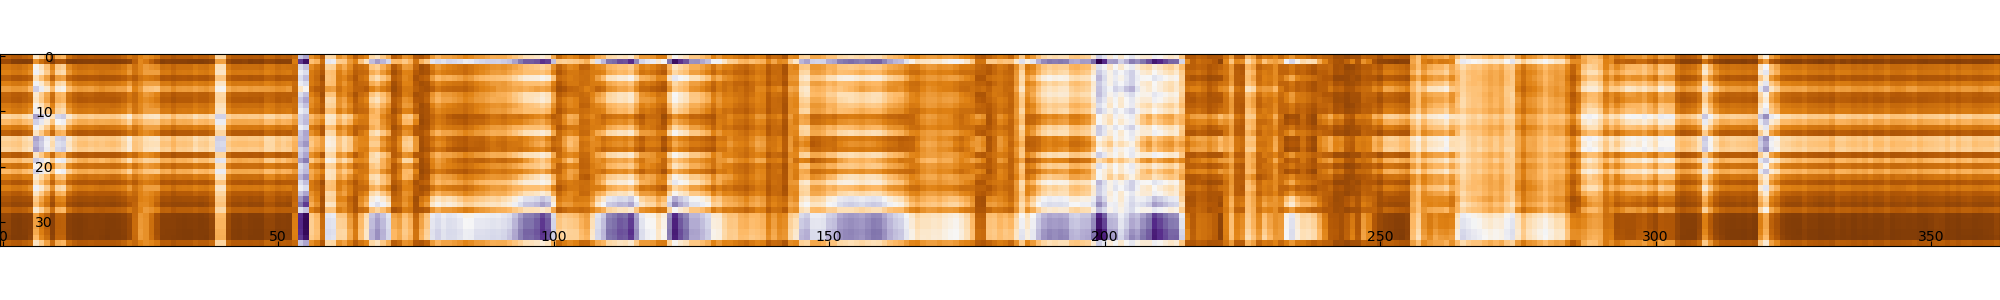

In [42]:
plot_matrix(new_b)

In [43]:
new_b.size()

torch.Size([363, 35])

In [44]:
new_b

tensor([[2179.0754,  979.1580, 3050.7136,  ...,  628.4418,  506.6120,
         2179.0754],
        [2179.0754,  979.1580, 3050.7136,  ...,  628.4418,  506.6120,
         2179.0754],
        [1851.4753,  309.5866, 2743.4512,  ...,  176.7644,  159.0086,
         1851.4753],
        ...,
        [1845.1085,  394.5885, 2707.2690,  ...,  257.6742,  198.3913,
         1845.1085],
        [1870.6954,  491.4756, 2772.1882,  ...,  299.2505,  253.8689,
         1870.6954],
        [2179.0754,  979.1580, 3050.7136,  ...,  628.4418,  506.6120,
         2179.0754]])

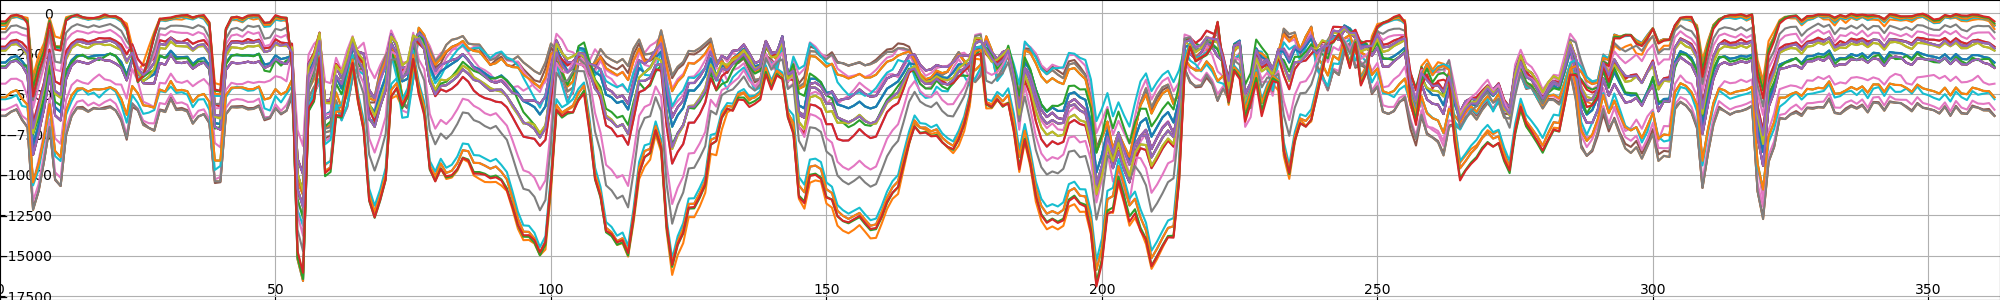

In [45]:
plot_fun(-new_b)

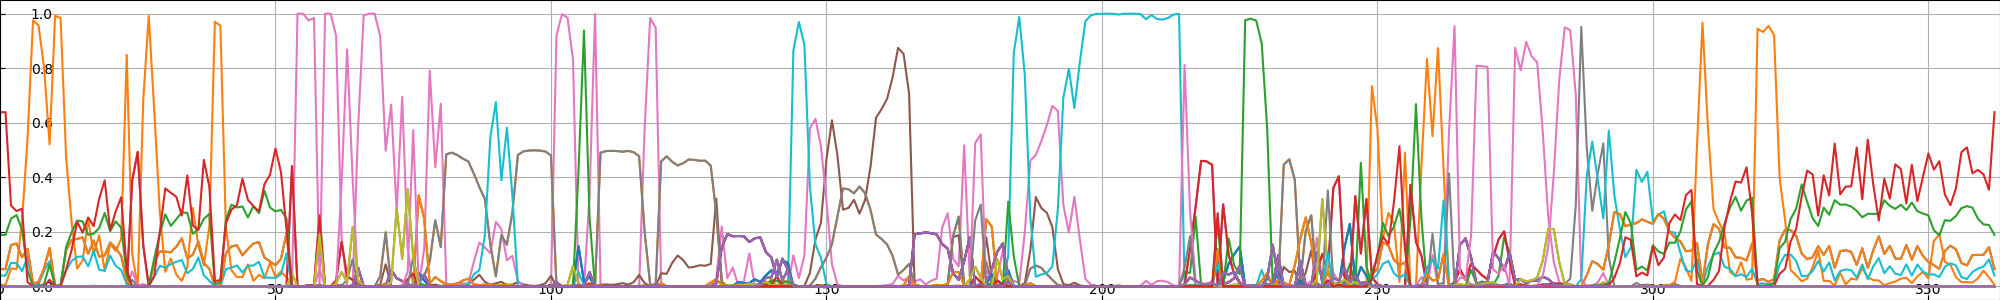

In [46]:
#plot_fun(torch.nn.Softmax(-new_b).float())

plot_fun(torch.nn.Softmax(dim=1)(-new_b/1e2))



In [47]:
b.size()

torch.Size([363, 35])

In [48]:
new_b.size()

torch.Size([363, 35])

In [49]:
b = m(torch.nn.Softmax(dim=1)(-new_b/1e2))

/home/hanzl/f-w/prak/acmodel/matrix.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val = torch.tensor(val, device=device).float()


In [50]:
b

m(tensor([[3.4822e-08, 5.6627e-03, 5.7066e-12,  ..., 1.8887e-01, 6.3866e-01,
         3.4822e-08],
        [3.4822e-08, 5.6627e-03, 5.7066e-12,  ..., 1.8887e-01, 6.3866e-01,
         3.4822e-08],
        [1.3230e-08, 6.5753e-02, 1.7692e-12,  ..., 2.4817e-01, 2.9639e-01,
         1.3230e-08],
        ...,
        [2.8988e-08, 5.7776e-02, 5.2228e-12,  ..., 2.2718e-01, 4.1098e-01,
         2.8988e-08],
        [3.3685e-08, 3.2909e-02, 4.0954e-12,  ..., 2.2497e-01, 3.5418e-01,
         3.3685e-08],
        [3.4822e-08, 5.6627e-03, 5.7066e-12,  ..., 1.8887e-01, 6.3866e-01,
         3.4822e-08]]))

In [51]:
torch.nn.Softmax([100,20,2000,5]).float()

Softmax(dim=[100, 20, 2000, 5])

In [52]:
x = [[1,2],
    [3,4]]

In [53]:
torch.nn.Softmax(x)

Softmax(dim=[[1, 2], [3, 4]])

In [54]:
vector = torch.tensor([1.5, -3.5, 2.0])
probabilities = torch.nn.Softmax(dim=-1)(vector)
print("Probability Distribution is:")
print(probabilities)

Probability Distribution is:
tensor([0.3766, 0.0025, 0.6209])


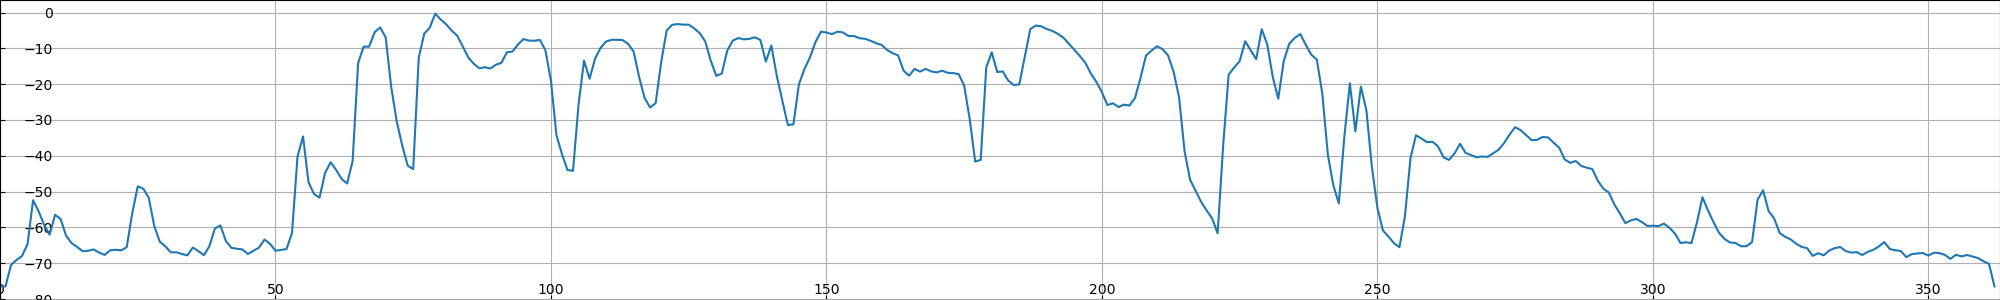

In [55]:
plot_fun(mfcc[:,0])

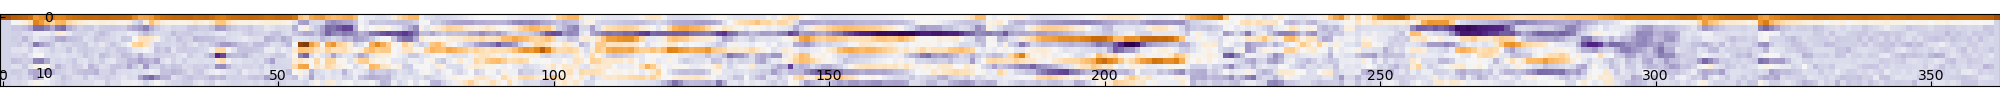

In [56]:
plot_matrix(mfcc, figsize=(20,1))

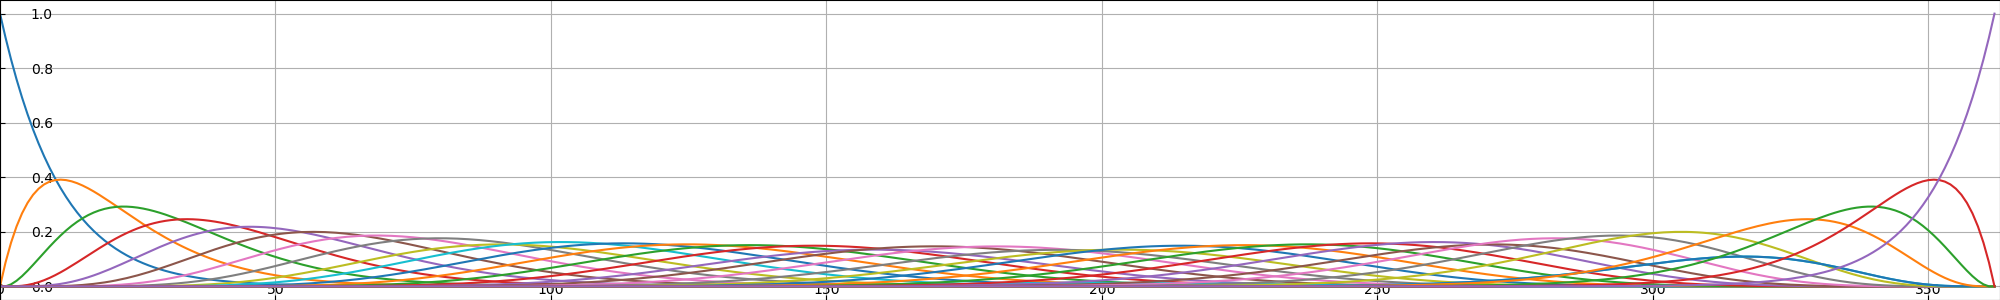

In [57]:
plot_fun(X)

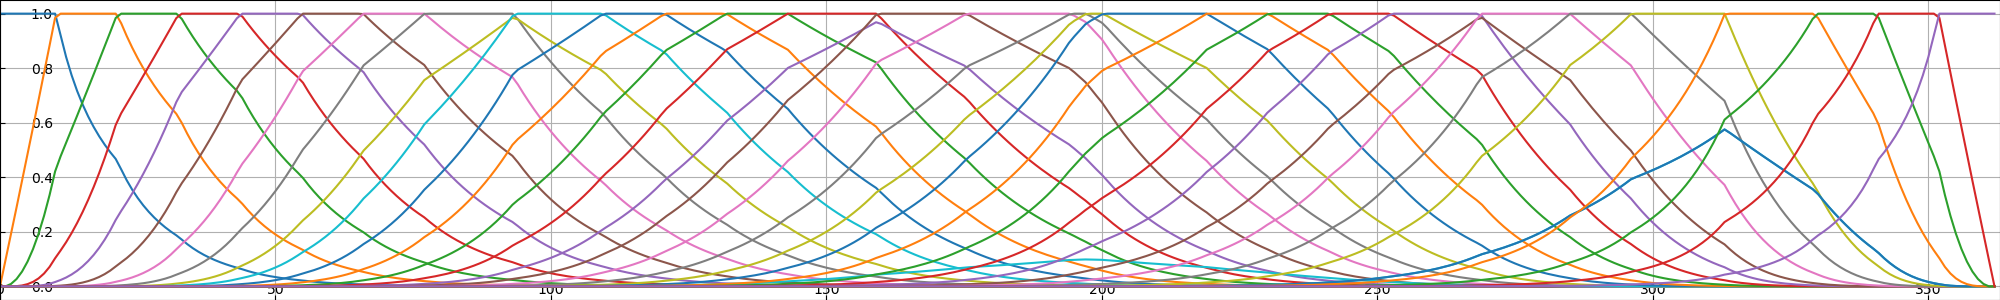

In [58]:
plot_fun(Y)

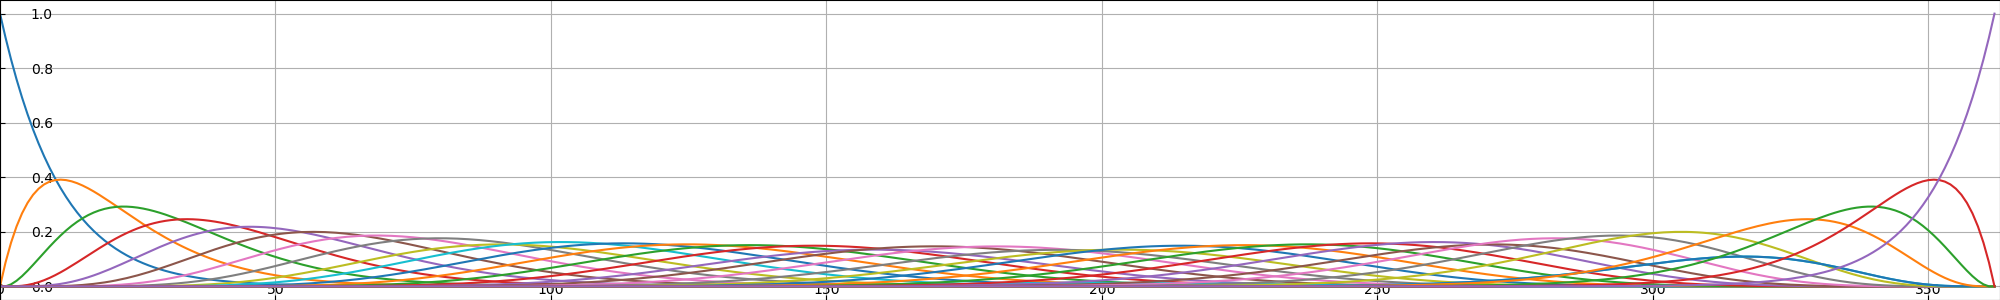

In [59]:
plot_fun(X)

In [60]:
X

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9126, 0.0874, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8326, 0.1600, 0.0074,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0074, 0.1600, 0.8326],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0874, 0.9126],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])

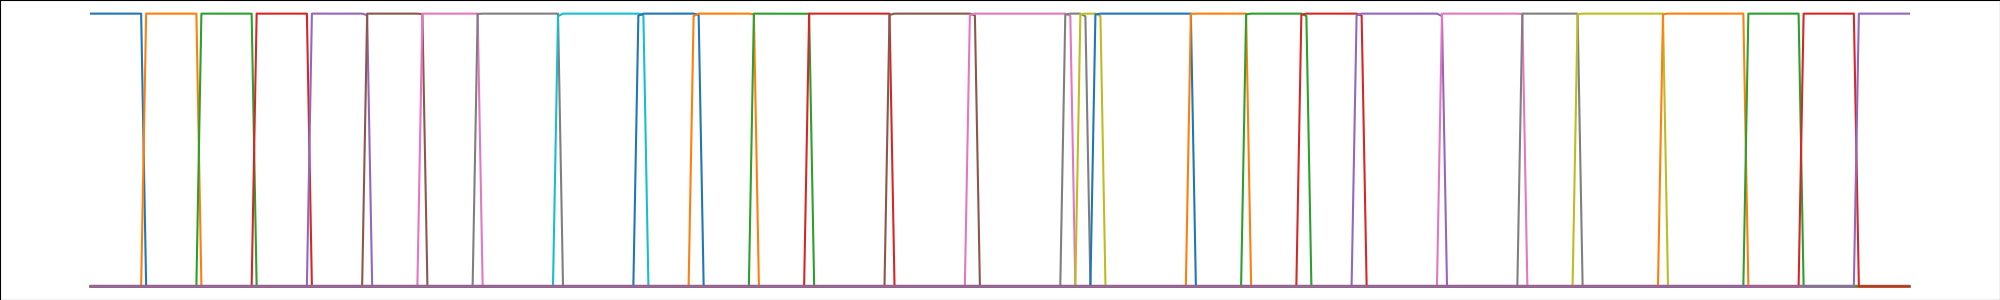

In [61]:
plt.clf()
p = plt.plot(Y*(Y>0.99))
plt.show()

In [62]:
i = X.max(1).indices

In [63]:
"".join([hmm.b[ii] for ii in i])

'|||||||||||gggggggggggdddddddddddooooooooooohhhhhhhhhhhoooooooooooďďďďďďďďďďďďeeeeeeeeeeeeeeeeddddddddddddddddooooooooooošššššššššššlllllllllllooooooooooooooooojjjjjjjjjjjjjjjjyyyyyyyyyyyyyyyyyyyššš|||dddddddddddddddddddlllllllllllOOOOOOOOOOOhhhhhhhhhhhooooooooooooooooppppppppppppppppŘŘŘŘŘŘŘŘŘŘŘŘeeeeeeeeeeeeeeeeeťťťťťťťťťťťťťťťťýýýýýýýýýýýmmmmmmmmmmm|||||||||||'

In [64]:
hmm.wav

'/home/hanzl/f-w/prak/common_voice_cs_23962589.wav'

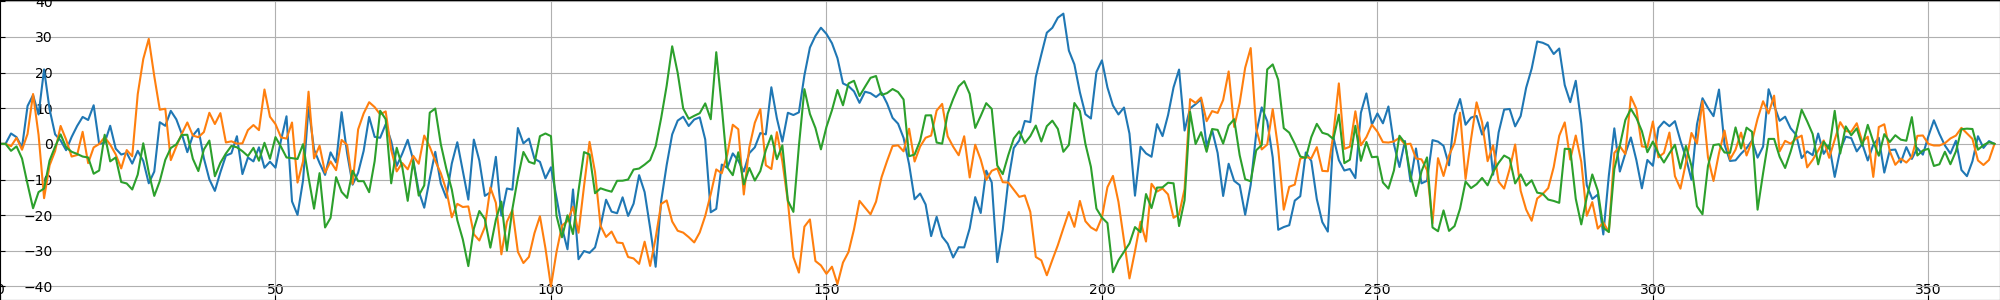

In [65]:
plot_fun(mfcc[:,10:])

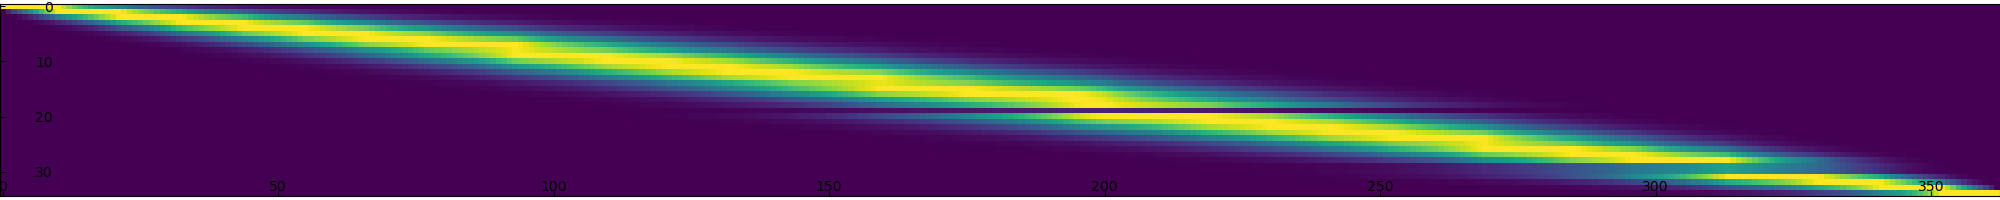

In [66]:
plot_matrix(Y,cmap='viridis', figsize=(20,2))

'spectral' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

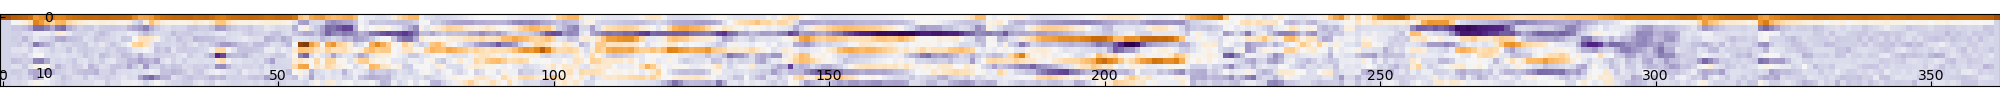

In [67]:
plot_matrix(mfcc, figsize=(20,1))

In [68]:
mfcc.size(), mfcc[None].size(), mfcc[:, None].size()

(torch.Size([363, 13]), torch.Size([1, 363, 13]), torch.Size([363, 1, 13]))

In [69]:
d = mfcc[None] - mfcc[:, None]

In [70]:
d.size()

torch.Size([363, 363, 13])

In [71]:
dd = d ** 2

In [72]:
ddd = dd.sum(2)

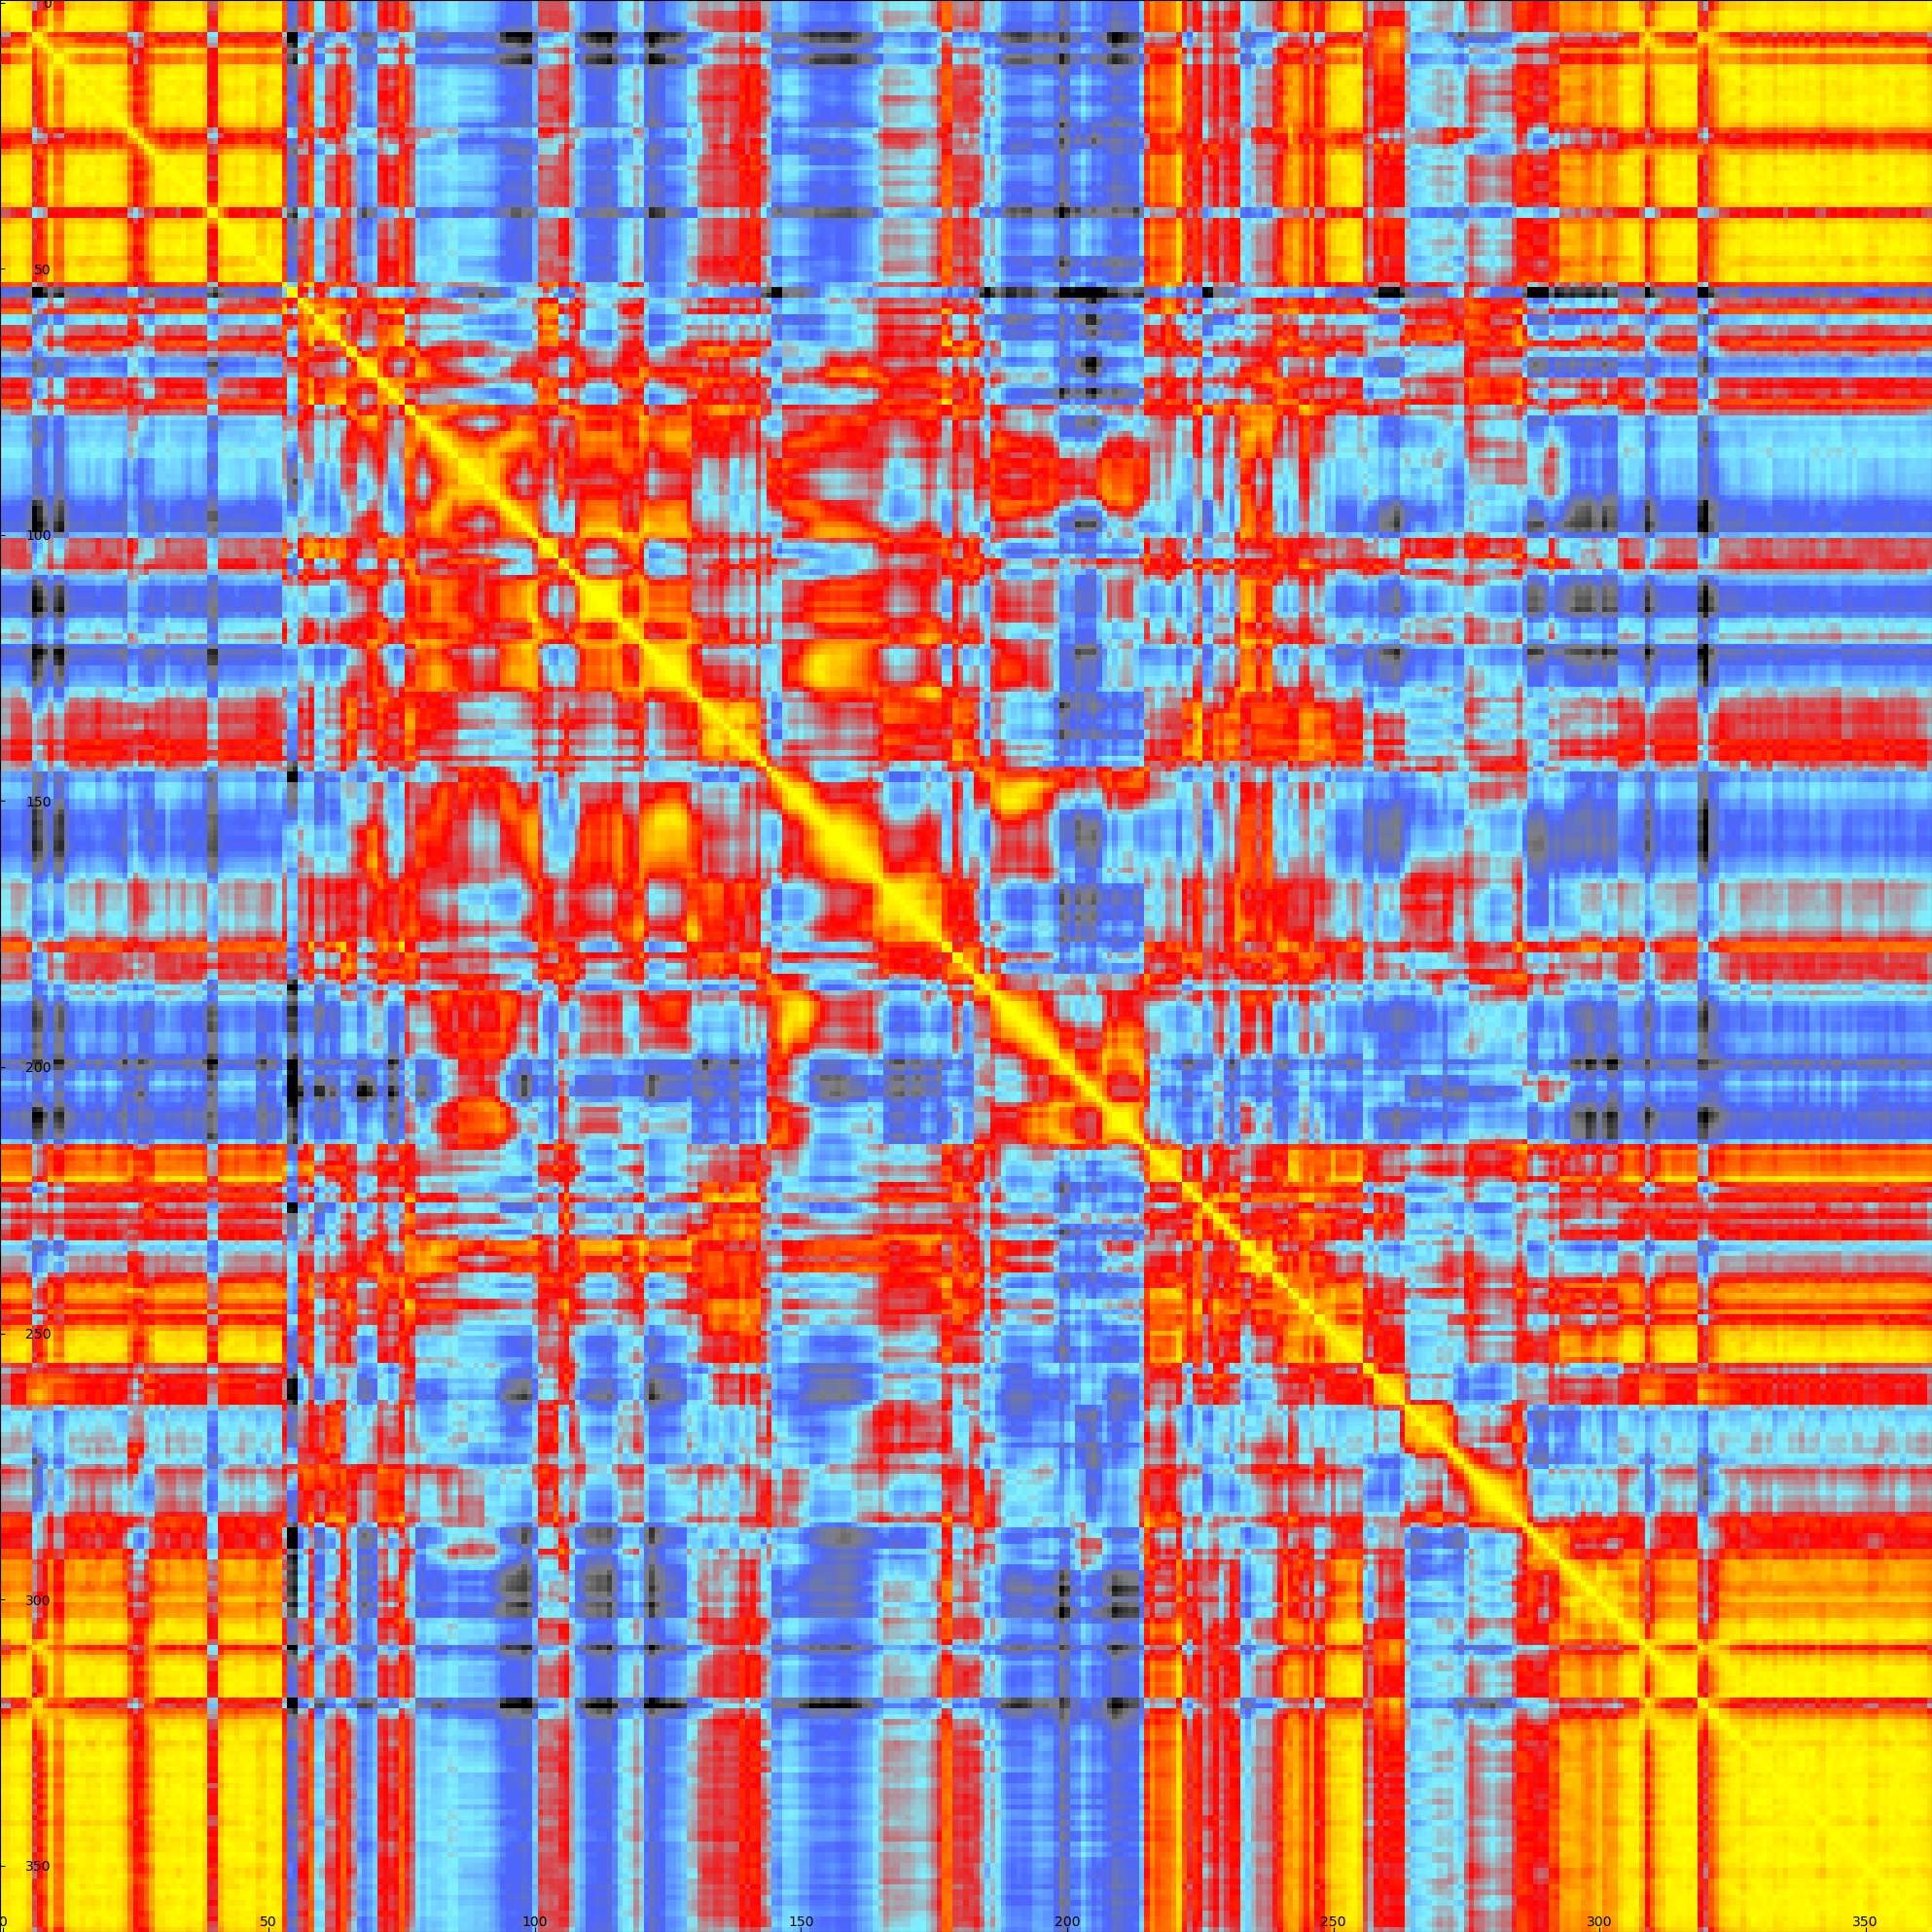

In [73]:
#plot_matrix(ddd, cmap='hsv')
#plot_matrix(ddd, cmap=['twilight_shifted','twilight','gist_ncar','nipy_spectral','turbo','jet','rainbow','gist_rainbow','ocean','terrain'][-1]   )
#plot_matrix(ddd, cmap=['twilight_shifted', 'gist_stern', 'gnuplot', 'gnuplot2', 'RdBu'][-1]   )
#plot_matrix(ddd, cmap=['Spectral'][-1]   )
#plot_matrix(ddd, cmap=['viridis', 'plasma', 'inferno','magma','cividis'][-1]   )


from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


colors = ["cyan", "darkorange", "gold", "lawngreen", "lightseagreen", "black"]

colors = ["black", "yellow", "red", "cyan", "darkorange", "gold", "lawngreen", "lightseagreen", "black"]
colors = [(1,1,0), (0,1,0), (1,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0),
          (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0)]

colors = [(1,0.8,0.6), (1,1,1), (0.7,0.7,0.7), (0.5,0.5,0.5), (0.3,0.3,0.3), (0.3,0.3,0.5), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0),
          (0,0,0), (0,0,0), (1,0,0), (0,0,0), (0,0,0), (0,0,0), (0.5,0,0), (0,0,0), (0,0,0)]


colors = ["red","yellow","green","blue","black", "darkblue"]
colors = ["lightgreen","green","red","yellow","green","blue","black", "darkblue"]
colors = ["lightgreen","green","yellow","red","green","blue","black", "darkblue"]
colors = ["white","green","yellow","red","cyan","blue","black", "darkblue"]

colors = list(reversed(["white","green","yellow","red","cyan","blue","black", "darkblue"]))

colors = ["cyan","blue","yellow","red","gray","blue","black", "darkblue"]
colors = ["cyan","blue","yellow","red","gray","black","black", "black"]
colors = [(0.7,0.9,1),"blue","yellow","red","gray","black","black", "black"]
colors = [(0.7,0.9,1),(0.3,0.4,1),"yellow","red","gray","black","black", "black"]
colors = [(0.5,0.95,1),(0.3,0.4,1),"yellow","red","gray","black","black", "black"]

colors = ["yellow","red",(0.5,0.95,1),(0.3,0.4,1),"gray","black","black", "black"]

cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
plot_matrix(ddd, cmap=cmap1, figsize=(19.86, 19.86))


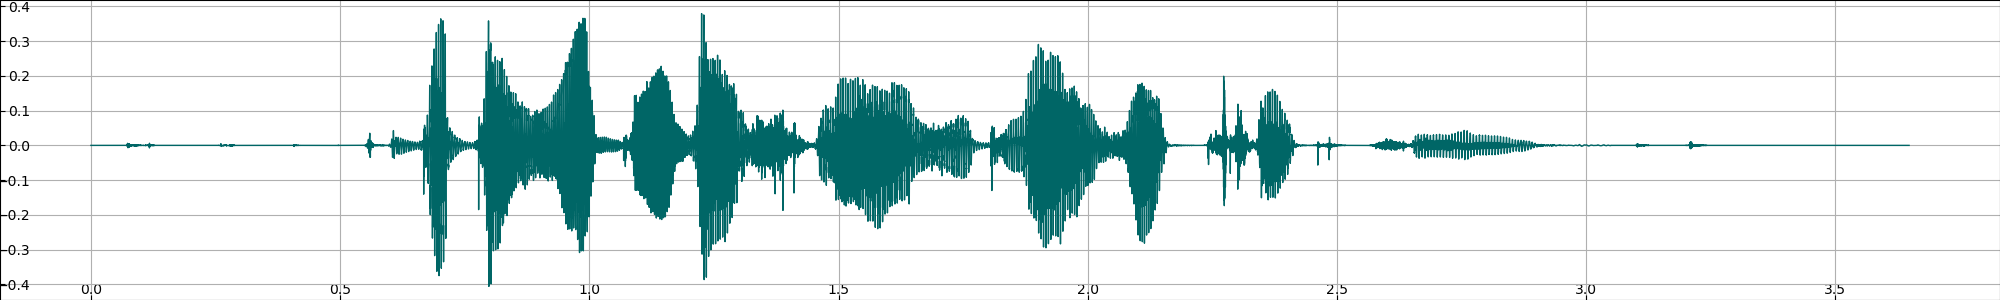

In [74]:
plot_waveform(waveform, sample_rate)

/home/hanzl/mambaforge/envs/mjup2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7628: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


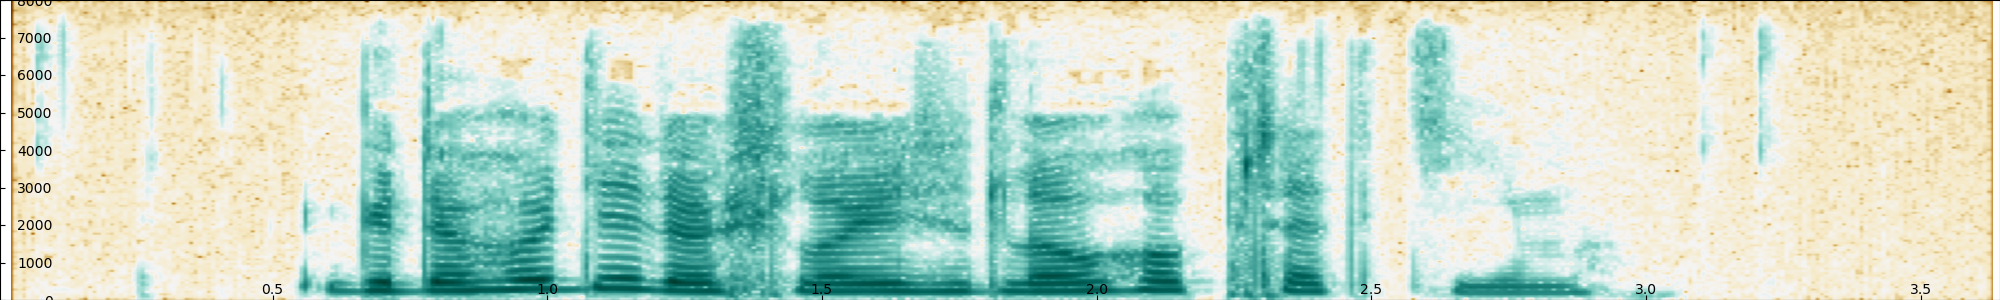

In [75]:
plot_specgram(waveform, sample_rate)

In [76]:
print(hmm)

------ sentence and HMM ------
 WAV: /home/hanzl/f-w/prak/common_voice_cs_23962589.wav
ORTO: k dohodě došlo již dlouho předtím
                     |         |
PRON: |g.dohoďe.došlo.jyš|dlOho.pŘetťým|
               |        ž          ť
   | g d o h o ď e | d o š l o | j y š | ž d l O h o | p Ř e t ť ť ý m |
 | 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
 g . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
 d . . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
 o . . . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
 h . . . . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
 o . . . . . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . .
 ď . . . . . . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . . .
 e . . . . . . . 1 1 1 . . . . . . . . . . . . . . . . . . . . . . . . .
 | . . . . . . . . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . .
 d . . . . . . . . . 1 1 . . . .

# Compute new means based on L

In [77]:
# Mean
tensor.mean()

# Standard Deviation
tensor.std()

NameError: name 'tensor' is not defined

In [ ]:
# Mean
tensor.mean()

# Standard Deviation
tensor.std()

In [ ]:
len(hmm.b), len({*hmm.b})